In [1]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
from collections import Counter
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import pickle
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier

In [2]:
file_path = 'news.csv'
df = pd.read_csv(file_path, index_col=0)

print("Primeras 5 filas del DataFrame:")
df.head()

Primeras 5 filas del DataFrame:


,title,text,label
8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


In [3]:
X = df[['title', 'text']]
y = df['label']

In [4]:
print("\nColumnas del conjunto X:")
print(X.columns)

print("\nNúmero de filas y columnas del conjunto X:")
print(X.shape)

print("\nResumen de la información del conjunto X:")
X.info()

print("\nResumen de la información del conjunto 'y':")
y.info()
print("Número de elementos en 'y':", y.shape[0])


Columnas del conjunto X:
Index(['title', 'text'], dtype='object')

Número de filas y columnas del conjunto X:
(6335, 2)

Resumen de la información del conjunto X:
<class 'pandas.core.frame.DataFrame'>
Index: 6335 entries, 8476 to 4330
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   6335 non-null   object
 1   text    6335 non-null   object
dtypes: object(2)
memory usage: 148.5+ KB

Resumen de la información del conjunto 'y':
<class 'pandas.core.series.Series'>
Index: 6335 entries, 8476 to 4330
Series name: label
Non-Null Count  Dtype 
--------------  ----- 
6335 non-null   object
dtypes: object(1)
memory usage: 99.0+ KB
Número de elementos en 'y': 6335


In [5]:
print("\nInformación del conjunto X:")
print("Número de títulos únicos:", X['title'].nunique())
print("Número de textos únicos:", X['text'].nunique())

print("\nValores únicos en el conjunto 'y':")
print(y.value_counts())


Información del conjunto X:
Número de títulos únicos: 6256
Número de textos únicos: 6060

Valores únicos en el conjunto 'y':
label
REAL    3171
FAKE    3164
Name: count, dtype: int64


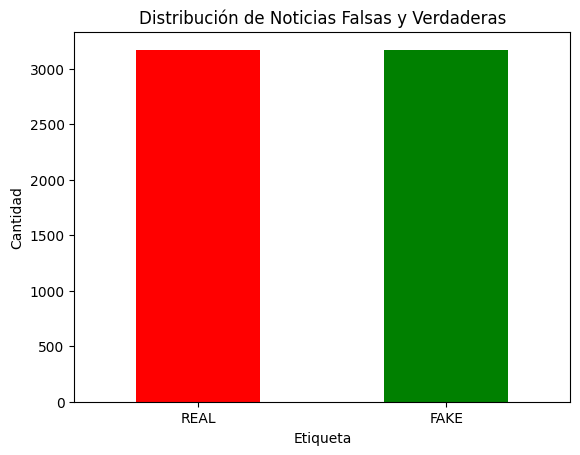

In [6]:
y_series = pd.Series(y)

# Gráfico de barras de la distribución de noticias falsas y verdaderas
y_series.value_counts().plot(kind='bar', color=['red', 'green'])
plt.title('Distribución de Noticias Falsas y Verdaderas')
plt.xlabel('Etiqueta')
plt.ylabel('Cantidad')
plt.xticks(rotation=0)
plt.show()


Nos encontramos ante un problema de distribución balanceada, lo que significa que el conjunto de datos contiene aproximadamente el mismo número de noticias falsas que de noticias reales. Esto es importante porque en problemas de clasificación, una distribución balanceada ayuda a que el modelo de aprendizaje automático no se sesgue hacia una clase en particular. En otras palabras, el modelo tendrá la misma cantidad de ejemplos para aprender a identificar tanto noticias falsas como noticias reales, lo que puede mejorar su capacidad para generalizar y hacer predicciones precisas en nuevos datos.

In [7]:
duplicates = X.duplicated().sum()
print(f"Número de registros duplicados en X: {duplicates}")

Número de registros duplicados en X: 29


In [8]:
duplicates = X[X.duplicated(keep=False)]
print("Registros duplicados en X:")
print(duplicates)

Registros duplicados en X:
                                                   title  \
636    Anti-Trump forces seek last-ditch delegate revolt   
4410   Loretta Lynch becomes first African-American w...   
739    Do Democrats Want What Bernie Wants, Or Just W...   
9652   Hillary’s “Big Tent” is Obama’s “Grand Bargain...   
2905       US faces calls to ‘walk away’ from Iran talks   
2237   University of Missouri, please immediately fir...   
6632         Black Agenda Radio for Week of Nov. 7, 2016   
4096   There’s a good reason protesters at the Univer...   
666    Donald Trump is blatantly racist — and the med...   
8391   North Korea Threatens ‘Sacred’ Nuclear War Aga...   
3037   This astonishing chart shows how moderate Repu...   
2697   University of Missouri, please immediately fir...   
576      The College Loan Bombshell Hidden in the Budget   
5608      Fighting Ghost Fascists While Aiding Real Ones   
2401   Obamacare Enrollees Anxiously Await Supreme Co...   
4544   Lorett

In [9]:
duplicate_indices = X[X.duplicated()].index

X_clean = X.drop(duplicate_indices)

y_clean = y.drop(duplicate_indices)

print(f"X después de eliminar duplicados tiene {X_clean.shape[0]} registros.")
print(f"y después de eliminar duplicados tiene {y_clean.shape[0]} registros.")

X después de eliminar duplicados tiene 6306 registros.
y después de eliminar duplicados tiene 6306 registros.


Juntamos ahora tanto X como y para facilitar la manipulación, este será el nuevo df sin duplicados.

In [10]:
df_clean = pd.concat([X_clean, y_clean], axis=1)

In [11]:
# Añadir nuevas variables para la longitud de títulos y textos
df_clean['title_length'] = df_clean['title'].apply(len)
df_clean['text_length'] = df_clean['text'].apply(len)

# Calcular la longitud promedio de títulos y textos para noticias reales y falsas
avg_lengths = df_clean.groupby('label').agg({
    'title_length': 'mean',
    'text_length': 'mean'
}).reset_index()

# Renombrar columnas para mayor claridad
avg_lengths.columns = ['label', 'avg_title_length', 'avg_text_length']

print(avg_lengths)

  label  avg_title_length  avg_text_length
0  FAKE         69.171320      4119.766497
1  REAL         61.386493      5294.741598


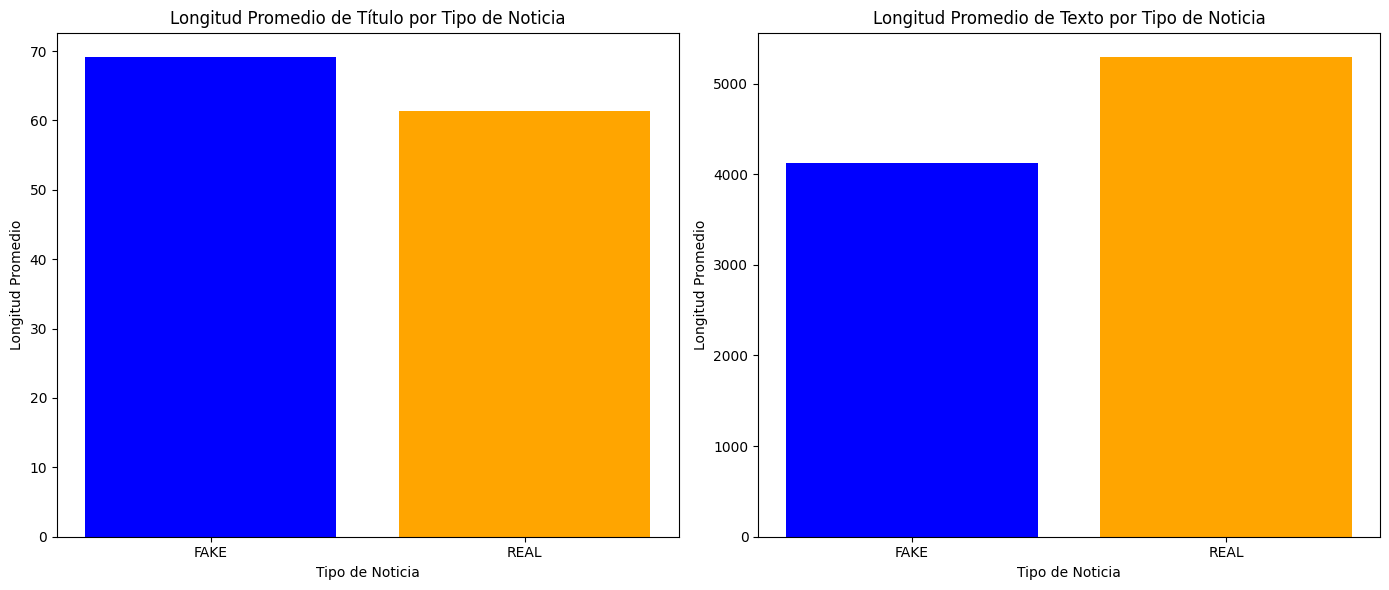

In [12]:
# Crear gráficos de barras
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Título promedio
ax[0].bar(avg_lengths['label'], avg_lengths['avg_title_length'], color=['blue', 'orange'])
ax[0].set_title('Longitud Promedio de Título por Tipo de Noticia')
ax[0].set_ylabel('Longitud Promedio')
ax[0].set_xlabel('Tipo de Noticia')

# Texto promedio
ax[1].bar(avg_lengths['label'], avg_lengths['avg_text_length'], color=['blue', 'orange'])
ax[1].set_title('Longitud Promedio de Texto por Tipo de Noticia')
ax[1].set_ylabel('Longitud Promedio')
ax[1].set_xlabel('Tipo de Noticia')

plt.tight_layout()
plt.show()

Esto indica que, en este conjunto de datos, las noticias falsas tienden a tener títulos ligeramente más largos en promedio, mientras que las noticias reales tienden a tener textos más extensos.

A continuación, descargamos los recursos necesarios de la biblioteca NLTK (Natural Language Toolkit) en Python, que es ampliamente utilizada para el procesamiento del lenguaje natural (NLP). Los recursos específicos que se están descargando son:

- Punkt: Es un tokenizador de palabras y oraciones. Se utiliza para dividir el texto en una lista de oraciones o palabras. Este tokenizador utiliza un modelo entrenado que entiende el idioma para encontrar los puntos de división.

- Stopwords: Son palabras comunes que generalmente se consideran irrelevantes para el análisis de texto porque aparecen frecuentemente en el lenguaje pero no aportan mucho significado por sí solas, como "y", "o", "pero", etc. Este recurso contiene listas de estas palabras para varios idiomas.

In [13]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Alejandro\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Alejandro\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [14]:
def limpiar_texto(texto):
    tokens = word_tokenize(texto.lower())  # Convertir a minúsculas y tokenizar
    palabras_sin_stopwords = [palabra for palabra in tokens if palabra.isalpha() and palabra not in stopwords.words('english')]
    return palabras_sin_stopwords

In [15]:
# Combinar título y texto, y aplicar la limpieza y tokenización
df_clean['combined'] = df_clean['title'] + " " + df_clean['text']
df_clean['tokens'] = df_clean['combined'].apply(limpiar_texto)

In [16]:
df_clean.head()

,title,text,label,title_length,text_length,combined,tokens
8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE,28,7518,You Can Smell Hillary’s Fear Daniel Greenfield...,"[smell, hillary, fear, daniel, greenfield, shi..."
10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE,85,2646,Watch The Exact Moment Paul Ryan Committed Pol...,"[watch, exact, moment, paul, ryan, committed, ..."
3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL,43,2543,Kerry to go to Paris in gesture of sympathy U....,"[kerry, go, paris, gesture, sympathy, secretar..."
10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE,84,2660,Bernie supporters on Twitter erupt in anger ag...,"[bernie, supporters, twitter, erupt, anger, dn..."
875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL,48,1840,The Battle of New York: Why This Primary Matte...,"[battle, new, york, primary, matters, primary,..."


In [17]:
df_clean['tokens']

8476     [smell, hillary, fear, daniel, greenfield, shi...
10294    [watch, exact, moment, paul, ryan, committed, ...
3608     [kerry, go, paris, gesture, sympathy, secretar...
10142    [bernie, supporters, twitter, erupt, anger, dn...
875      [battle, new, york, primary, matters, primary,...
                               ...                        
4490     [state, department, says, ca, find, emails, cl...
8062     [p, pbs, stand, plutocratic, pentagon, p, pbs,...
8622     [protesters, tools, oligarchy, information, pr...
4021     [ethiopia, obama, seeks, progress, peace, secu...
4330     [jeb, bush, suddenly, attacking, trump, matter...
Name: tokens, Length: 6306, dtype: object

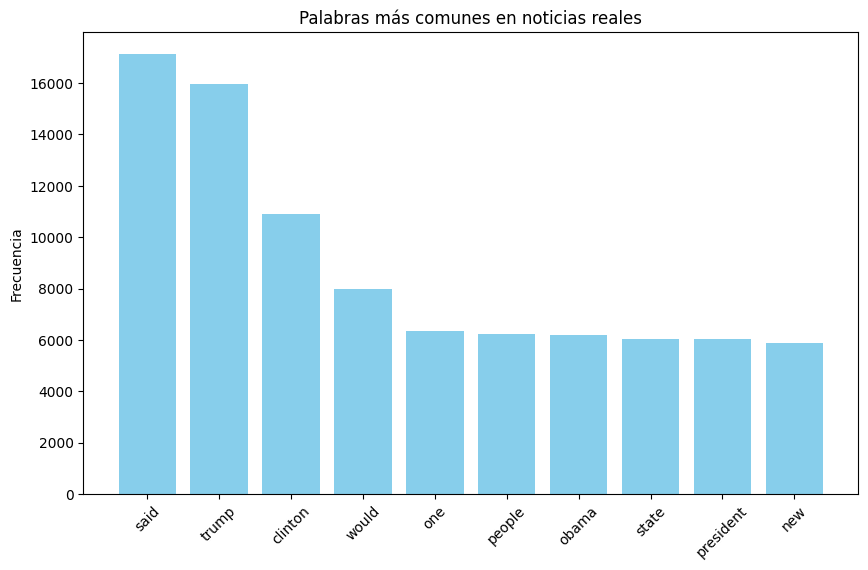

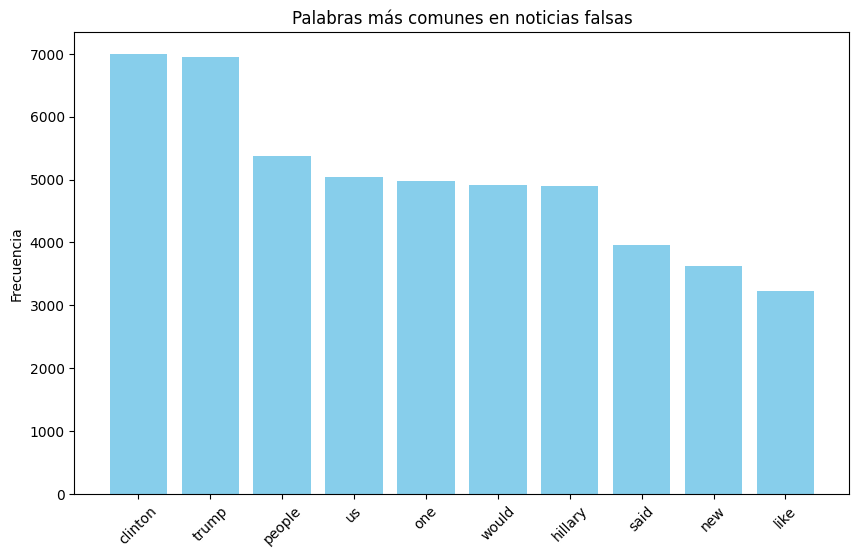

In [18]:
# Separar los DataFrames por etiqueta
df_real = df_clean[df_clean['label'] == 'REAL']
df_fake = df_clean[df_clean['label'] == 'FAKE']

# Contar frecuencias de palabras
frecuencias_real = Counter([palabra for tokens in df_real['tokens'] for palabra in tokens])
frecuencias_fake = Counter([palabra for tokens in df_fake['tokens'] for palabra in tokens])

# Obtener las 10 palabras más comunes para noticias reales y falsas
mas_comunes_real = frecuencias_real.most_common(10)
mas_comunes_fake = frecuencias_fake.most_common(10)

def graficar_palabras_comunes(mas_comunes, titulo):
    palabras = [palabra[0] for palabra in mas_comunes]
    valores = [valor[1] for valor in mas_comunes]
    plt.figure(figsize=(10, 6))
    plt.bar(palabras, valores, color='skyblue')
    plt.title(titulo)
    plt.xticks(rotation=45)
    plt.ylabel('Frecuencia')
    plt.show()

# Graficar las palabras más comunes para noticias reales y falsas
graficar_palabras_comunes(mas_comunes_real, 'Palabras más comunes en noticias reales')
graficar_palabras_comunes(mas_comunes_fake, 'Palabras más comunes en noticias falsas')

A continuación, se cuentan las palabras más comunes en las noticias falsas y reales, teniendo en cuenta todas las palabras, no solo las tokenizadas.

In [19]:
from collections import Counter
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer

# Función para obtener palabras más comunes
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]

# Mostrar las palabras más comunes en noticias falsas y verdaderas
fake_texts = df[df['label'] == 'FAKE']['text']
real_texts = df[df['label'] == 'REAL']['text']

print("\nPalabras más comunes en noticias falsas:")
print(get_top_n_words(fake_texts, 20))

print("\nPalabras más comunes en noticias verdaderas:")
print(get_top_n_words(real_texts, 20))



Palabras más comunes en noticias falsas:
[('the', 129572), ('of', 61012), ('to', 60137), ('and', 55139), ('in', 40577), ('that', 30424), ('is', 27172), ('for', 19615), ('it', 17927), ('on', 16082), ('as', 14413), ('with', 13471), ('this', 12882), ('are', 12854), ('by', 12399), ('be', 11694), ('was', 11157), ('have', 10605), ('not', 9994), ('they', 9564)]

Palabras más comunes en noticias verdaderas:
[('the', 161460), ('to', 79744), ('of', 68847), ('and', 65003), ('in', 58160), ('that', 42171), ('is', 27263), ('for', 26863), ('on', 24775), ('he', 23924), ('it', 21670), ('as', 18189), ('with', 17407), ('said', 17203), ('his', 16079), ('was', 15978), ('trump', 15702), ('but', 13730), ('have', 13660), ('at', 13364)]


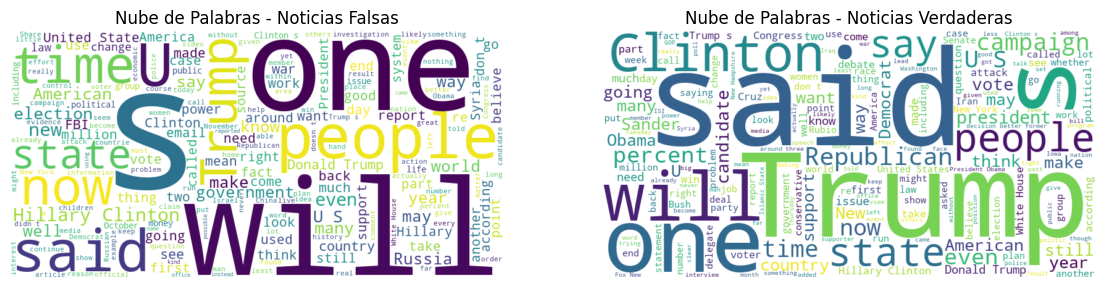

In [21]:
# Generar nubes de palabras
fake_text = ' '.join(fake_texts)
real_text = ' '.join(real_texts)

wordcloud_fake = WordCloud(width=800, height=400, background_color='white').generate(fake_text)
wordcloud_real = WordCloud(width=800, height=400, background_color='white').generate(real_text)

# Mostrar nubes de palabras
plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
plt.imshow(wordcloud_fake, interpolation='bilinear')
plt.title('Nube de Palabras - Noticias Falsas')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_real, interpolation='bilinear')
plt.title('Nube de Palabras - Noticias Verdaderas')
plt.axis('off')

plt.show()


De aquí sacamos algunas conslusiones como:
- Palabras como "one", "will", "said", "people" y "time" son prominentes. Estas palabras son comunes en la narrativa de muchas noticias y no necesariamente indicativas de contenido falso o verdadero por sí mismas.
- La palabra "will" (futuro) sugiere un enfoque en promesas o predicciones, lo cual es común en noticias que intentan influir en la opinión pública mediante afirmaciones sobre el futuro.
"Trump" y "Clinton" también aparecen, indicando un enfoque en figuras políticas prominentes, lo que es típico durante ciclos electorales.
- Palabras como "one" y "people" pueden indicar una tendencia a hacer generalizaciones amplias, que es una característica común en noticias falsas para crear un sentimiento de inclusión o alarma.
- La alta frecuencia de "said" indica un enfoque en reportar lo que otras personas han dicho, lo cual es típico de noticias verdaderas que citan fuentes verificables.
- Palabras como "campaign" y "percent" sugieren una cobertura más factual y cuantitativa de eventos políticos.


- Ambas nubes de palabras muestran una alta frecuencia de los nombres "Trump" y "Clinton", lo que indica que ambas categorías de noticias (falsas y verdaderas) se enfocan en figuras políticas prominentes.
- La nube de palabras de noticias falsas muestra palabras como "will", "one", y "people", que pueden ser indicativas de un estilo más general y menos preciso.
- La nube de palabras de noticias verdaderas muestra palabras como "said", "percent", y "campaign", que son más específicas y orientadas a hechos.

In [23]:
nltk.download('vader_lexicon')

sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Alejandro\AppData\Roaming\nltk_data...


In [24]:
def obtener_sentimiento(texto):
    sentimiento = sia.polarity_scores(texto)
    return sentimiento

In [28]:
df_clean['sentimiento'] = df_clean['combined'].apply(obtener_sentimiento)

In [33]:
primer_registro_sentimiento = df_clean.iloc[3450]['sentimiento']
print(primer_registro_sentimiento)

{'neg': 0.208, 'neu': 0.695, 'pos': 0.097, 'compound': -0.9984}


La puntuación compound es especialmente útil porque proporciona una única métrica que resume el sentimiento general del texto, ejemplo:

- Puntuación cercana a 1: Indica un sentimiento muy positivo.
- Puntuación cercana a -1: Indica un sentimiento muy negativo.
- Puntuación cercana a 0: Indica un sentimiento neutral.

In [36]:
# Separar los componentes de sentimiento
df_clean['compound'] = df_clean['sentimiento'].apply(lambda x: x['compound'])
df_clean['positiva'] = df_clean['sentimiento'].apply(lambda x: x['pos'])
df_clean['negativa'] = df_clean['sentimiento'].apply(lambda x: x['neg'])
df_clean['neutral'] = df_clean['sentimiento'].apply(lambda x: x['neu'])

# Promedio de sentimiento por etiqueta
sentimiento_promedio = df_clean.groupby('label')[['compound', 'positiva', 'negativa', 'neutral']].mean()
print(sentimiento_promedio)

       compound  positiva  negativa   neutral
label                                        
FAKE  -0.005204  0.088945  0.088955  0.822101
REAL   0.212891  0.094432  0.085677  0.819890


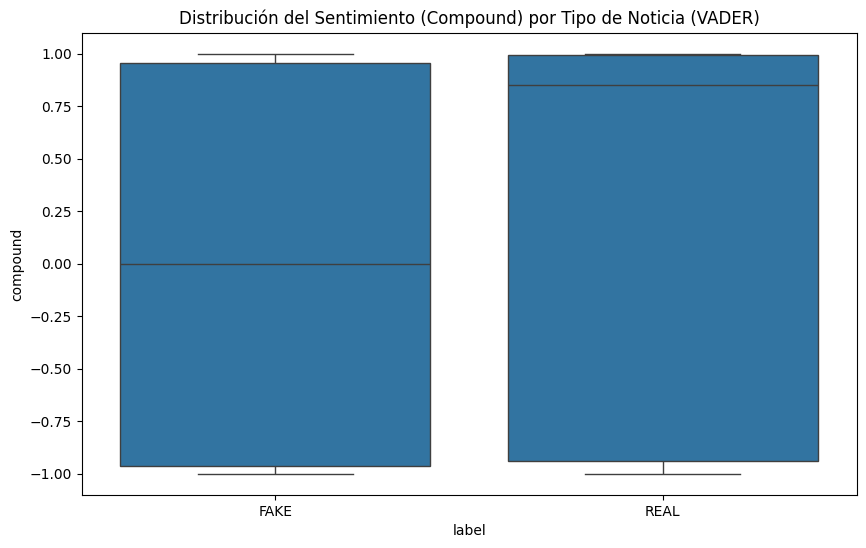

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns

# Gráfico de los resultados de VADER
plt.figure(figsize=(10, 6))
sns.boxplot(x='label', y='compound', data=df_clean)
plt.title('Distribución del Sentimiento (Compound) por Tipo de Noticia (VADER)')
plt.show()

- Noticias Falsas: La distribución del sentimiento compuesto en las noticias falsas parece más amplia, abarcando desde valores negativos (indicando sentimientos negativos) hasta valores positivos (indicando sentimientos positivos). Esto sugiere que las noticias falsas tienden a tener una mayor variabilidad en el tono emocional.
- Noticias Reales: La distribución del sentimiento compuesto en las noticias reales también muestra una amplia gama de valores, aunque parece estar ligeramente más sesgada hacia valores positivos en comparación con las noticias falsas.

# Modelos de clasficiación

In [43]:
df_clean.head()

,title,text,label,title_length,text_length,combined,tokens,sentimiento,compound,positiva,negativa,neutral,sentimiento_tb
8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE,28,7518,You Can Smell Hillary’s Fear Daniel Greenfield...,"[smell, hillary, fear, daniel, greenfield, shi...","{'neg': 0.182, 'neu': 0.731, 'pos': 0.087, 'co...",-0.9994,0.087,0.182,0.731,0.059595
10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE,85,2646,Watch The Exact Moment Paul Ryan Committed Pol...,"[watch, exact, moment, paul, ryan, committed, ...","{'neg': 0.081, 'neu': 0.828, 'pos': 0.09, 'com...",0.5119,0.090,0.081,0.828,0.085219
3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL,43,2543,Kerry to go to Paris in gesture of sympathy U....,"[kerry, go, paris, gesture, sympathy, secretar...","{'neg': 0.053, 'neu': 0.851, 'pos': 0.095, 'co...",0.9636,0.095,0.053,0.851,0.102574
10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE,84,2660,Bernie supporters on Twitter erupt in anger ag...,"[bernie, supporters, twitter, erupt, anger, dn...","{'neg': 0.093, 'neu': 0.824, 'pos': 0.083, 'co...",-0.6492,0.083,0.093,0.824,0.027543
875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL,48,1840,The Battle of New York: Why This Primary Matte...,"[battle, new, york, primary, matters, primary,...","{'neg': 0.084, 'neu': 0.743, 'pos': 0.173, 'co...",0.9897,0.173,0.084,0.743,0.252738


In [82]:
X = df_clean[['combined', 'title_length', 'text_length', 'sentimiento_tb', 'compound', 'positiva', 'negativa', 'neutral']]
y = df_clean['label']

In [83]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [84]:
# Vectorización TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train['combined'])
X_test_tfidf = vectorizer.transform(X_test['combined'])

# Convertir características adicionales en matrices dispersas (matriz en la que la mayoría de los elementos son cero)
# Estas características adicionales incluyen la longitud del título, la longitud del texto,
# y las puntuaciones de sentimiento obtenidas previamente.
additional_features_train = X_train[['title_length', 'text_length', 'sentimiento_tb', 'compound', 'positiva', 'negativa', 'neutral']].values
additional_features_test = X_test[['title_length', 'text_length', 'sentimiento_tb', 'compound', 'positiva', 'negativa', 'neutral']].values

# Aquí combinamos las características TF-IDF con las características adicionales en una sola matriz dispersa.
X_train_combined = hstack([X_train_tfidf, additional_features_train])
X_test_combined = hstack([X_test_tfidf, additional_features_test])

### Vectorización TF-IDF

En este bloque de código se utiliza la técnica **TF-IDF** (*Term Frequency - Inverse Document Frequency*) para transformar el texto en vectores numéricos que puedan ser procesados por modelos de Machine Learning.
  - Primero, se inicializa un objeto `TfidfVectorizer` con un límite de **5000 características**. Esto significa que el texto será transformado en vectores de una dimensión máxima de 5000, es decir, se seleccionarán las 5000 palabras más importantes basadas en su frecuencia en los textos.

- **`X_train_tfidf = vectorizer.fit_transform(X_train['combined'])`**  
  Aquí se aplica la vectorización sobre el conjunto de datos de entrenamiento (`X_train['combined']`), que contiene texto ya preprocesado (combinación de título, texto u otras características).  
  El método `fit_transform()` realiza dos tareas:
  1. **Ajuste (fit)**: Calcula las estadísticas necesarias (como frecuencias de las palabras y su relevancia) en el conjunto de entrenamiento.
  2. **Transformación (transform)**: Convierte el texto en una matriz dispersa de vectores TF-IDF que representan el texto de forma numérica.

- **`X_test_tfidf = vectorizer.transform(X_test['combined'])`**  
  Una vez que el vectorizador ha sido ajustado con el conjunto de entrenamiento, se aplica a los datos de prueba (`X_test['combined']`) utilizando solo la **transformación**.  
  Esto asegura que el mismo vocabulario y las mismas características utilizadas en el entrenamiento también se usen para el conjunto de prueba, transformando el texto en vectores TF-IDF.

#### ¿Qué es TF-IDF?
**TF-IDF** es una técnica que pondera la importancia de una palabra en un documento en relación a su aparición en todos los documentos:
- **TF (Term Frequency)**: Frecuencia de una palabra en un documento.
- **IDF (Inverse Document Frequency)**: Inverso de la frecuencia con que aparece una palabra en todos los documentos. Palabras comunes como "el" o "de" reciben menos peso.


C:\Users\Alejandro\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


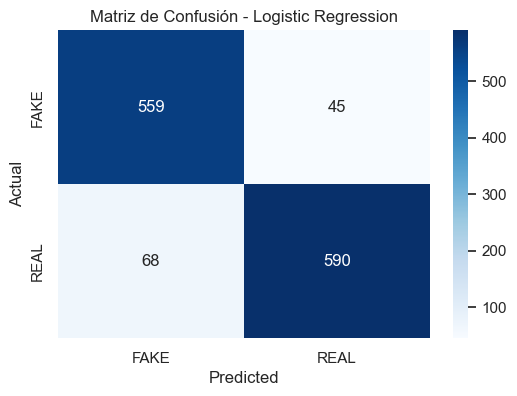

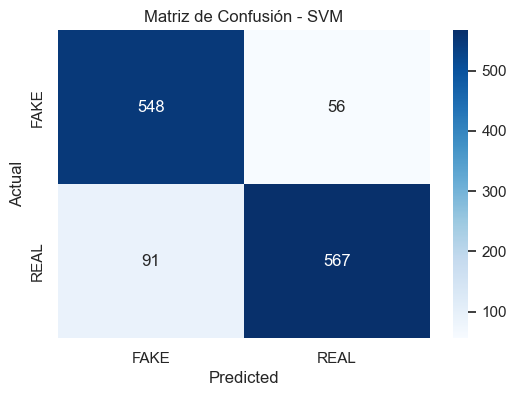

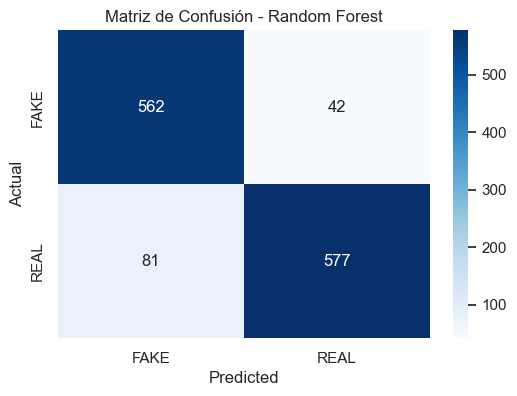

El modelo LogisticRegression ha sido guardado como 'best_model.pkl' junto con el vectorizador 'vectorizer.pkl'.


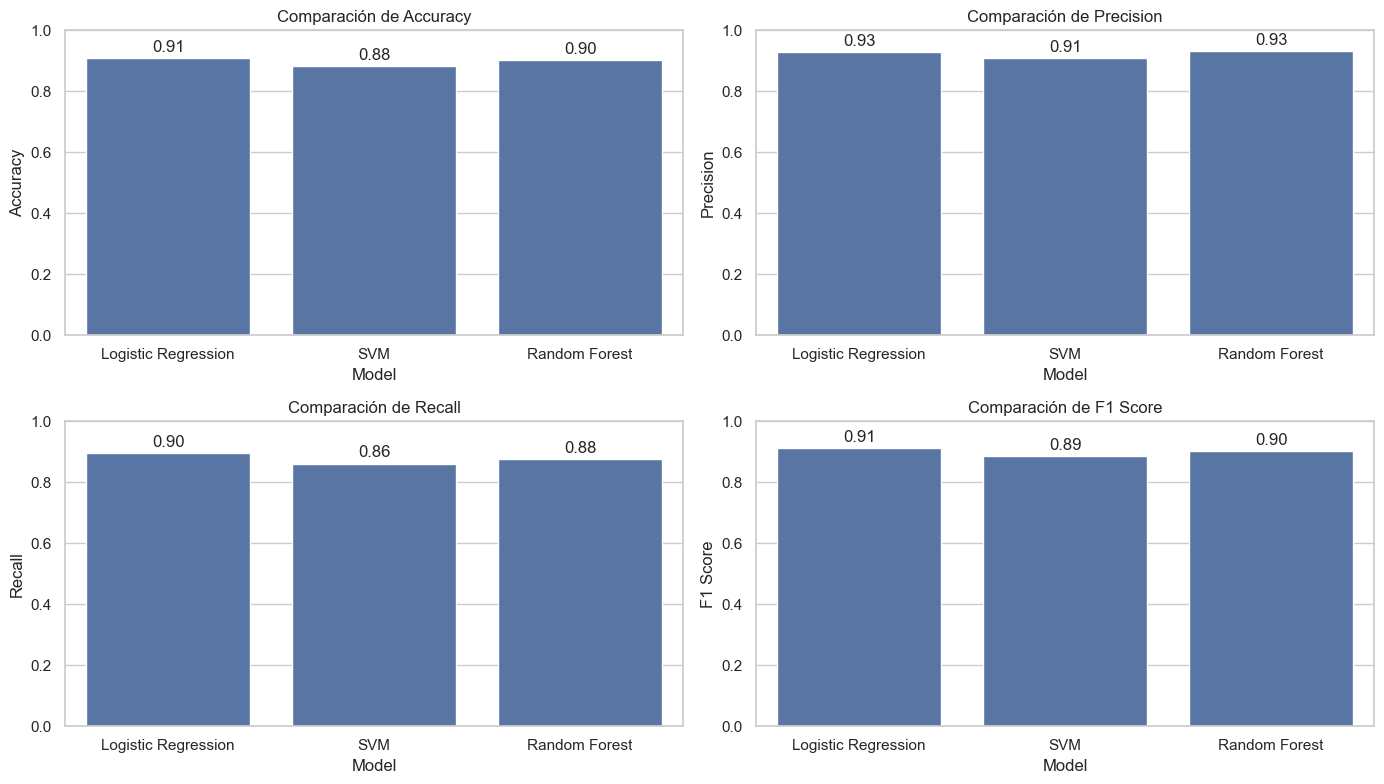

In [85]:
# Inicializar los modelos de clasificación
# Cada modelo tiene sus hiperparámetros configurados: Logistic Regression, SVM y Random Forest
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),  # Regresión logística con un máximo de 1000 iteraciones
    'SVM': LinearSVC(),  # Support Vector Machine (SVM) con LinearSVC
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42)  # Random Forest con 100 árboles y semilla 42
}

# Inicializar listas y variables para almacenar resultados y el mejor modelo
results = []  # Almacenará los resultados de cada métrica para cada modelo
confusion_matrices = {}  # Almacenará las matrices de confusión de cada modelo
best_model = None  # Variable para almacenar el mejor modelo (el que tenga mayor precisión)
best_accuracy = 0  # Inicializa la mejor precisión como 0

# Bucle para entrenar y evaluar cada modelo
for model_name, model in models.items():
    # Entrenar el modelo con los datos de entrenamiento
    model.fit(X_train_combined, y_train)
    
    # Realizar predicciones en el conjunto de prueba
    y_pred = model.predict(X_test_combined)
    
    # Calcular las métricas de rendimiento: exactitud, precisión, recall y F1-Score
    accuracy = accuracy_score(y_test, y_pred)  # Calcular la exactitud del modelo
    precision = precision_score(y_test, y_pred, pos_label='REAL', average='binary')  # Precisión para la clase "REAL"
    recall = recall_score(y_test, y_pred, pos_label='REAL', average='binary')  # Recall (sensibilidad) para la clase "REAL"
    f1 = f1_score(y_test, y_pred, pos_label='REAL', average='binary')  # F1-Score para la clase "REAL"
    
    # Almacenar los resultados de las métricas en una lista de diccionarios
    results.append({
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    })

    # Verificar si el modelo actual tiene la mejor precisión
    if accuracy > best_accuracy:
        best_accuracy = accuracy  # Actualizar la mejor precisión
        best_model = model  # Actualizar el mejor modelo
    
    # Calcular la matriz de confusión para el modelo actual
    cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
    confusion_matrices[model_name] = cm  # Almacenar la matriz de confusión

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=model.classes_, yticklabels=model.classes_)
    plt.title(f'Matriz de Confusión - {model_name}') 
    plt.xlabel('Predicted') 
    plt.ylabel('Actual') 
    plt.show()

# Guardar el mejor modelo entrenado en un archivo .pkl (usualmente el modelo Logistic Regression)
if best_model is not None:
    # Guardar el mejor modelo en un archivo llamado 'best_model.pkl'
    with open(r'backend\model\best_model.pkl', 'wb') as model_file:
        pickle.dump(best_model, model_file)
    
    # Guardar el vectorizador utilizado en un archivo .pkl
    with open(r'backend\model\vectorizer.pkl', 'wb') as vec_file:
        pickle.dump(vectorizer, vec_file)
    
    print(f"El modelo {type(best_model).__name__} ha sido guardado como 'best_model.pkl' junto con el vectorizador 'vectorizer.pkl'.")

# Crear un DataFrame con los resultados para facilitar su análisis
results_df = pd.DataFrame(results)

# Configurar el estilo de las gráficas con seaborn
sns.set(style="whitegrid")

# Definir las métricas a visualizar
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']

# Configurar el tamaño de la figura para las gráficas de barras
plt.figure(figsize=(14, 8))

# Crear una gráfica de barras para cada métrica y compararla entre los modelos
for i, metric in enumerate(metrics, 1):
    plt.subplot(2, 2, i)  # Crear subplots (2 filas, 2 columnas)
    sns.barplot(x='Model', y=metric, data=results_df)  # Gráfico de barras para cada métrica
    plt.title(f'Comparación de {metric}')  # Título con el nombre de la métrica
    plt.ylim(0, 1)  # Establecer límites para el eje y (entre 0 y 1)
    
    # Añadir los valores de las métricas en cada barra
    for index, value in enumerate(results_df[metric]):
        plt.text(index, value + 0.01, f'{value:.2f}', ha='center', va='bottom')  # Mostrar el valor en la barra

# Ajustar el espaciado entre los subplots para una mejor visualización
plt.tight_layout()

# Mostrar las gráficas
plt.show()

Regresión Logística es el mejor modelo general para nuestro conjunto de datos, ya que tiene los valores más altos en casi todas las métricas.

### Apunte: **¿Por qué es necesario guardar el vectorizador?**

Cuando se guarda un modelo entrenado (como el de **Regresión Logística**, **SVM** o **Random Forest**), este modelo está ajustado a los vectores numéricos que fueron creados a partir del texto original. Es crucial que, al hacer predicciones en el futuro, se transforme el texto de la misma manera que se hizo durante el entrenamiento.

Si no se guarda el vectorizador, pueden ocurrir los siguientes problemas:

- **Inconsistencia en la transformación de datos**:  
  Al intentar predecir con el modelo guardado, el texto nuevo no se podrá transformar correctamente, y el modelo no podrá procesarlo. Esto llevará a predicciones incorrectas o fallos en la ejecución.

- **Diferentes transformaciones**:  
  Si se intenta crear un nuevo vectorizador para el mismo modelo, el vocabulario o las frecuencias pueden ser diferentes. Esto hará que los vectores generados no sean consistentes con los que el modelo fue entrenado, lo que provocará que el rendimiento del modelo sea deficiente o incorrecto.
